#Dataset Description

##Preprocessed data taken from a study done by Nanyang Technological University Singapore

https://arxiv.org/abs/2106.00613



# Load Dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from scipy.io import loadmat
import numpy as np

# Path to the .mat file on your Google Drive
mat_file_path = '/content/drive/MyDrive/Capstone/dataset.mat'

# Load the .mat file
mat_data = loadmat(mat_file_path)


In [ ]:
patient_id = 11
EEGsample = mat_data['EEGsample']
subindex = mat_data['subindex']
substate = mat_data['substate']

patient_mask = subindex == patient_id
X = EEGsample[np.squeeze(patient_mask)]
y = substate[np.squeeze(patient_mask)]

In [ ]:
# X = mat_data['EEGsample']
# y = mat_data['substate']

In [ ]:
print(X.shape)

(226, 30, 384)


In [ ]:
oz_index = 28
X_oz = X[:, oz_index, :]

X_oz = np.expand_dims(X_oz, axis=-1)

In [ ]:
print(X[1, :, 1]);

[-11.22615931 -11.12787741  -6.73461545  -3.48004396  -7.81831953
   0.98593239  -2.81777062   0.04218041  -0.2624205   -2.03059563
  -3.818625    -1.17882003  -4.71072179   0.83932798   0.60842764
  -4.09385769  -1.62587816   0.04319128   4.20777069   0.56048348
  -4.55343992   1.24299237   4.19208643   5.06622103  -0.03400135
  -1.82732556   0.75918383  -2.68064295  -2.56195984  10.47079846]


In [ ]:
print(X_oz.shape)

(226, 384, 1)


# Build the Transformer Model

In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers, Model

def get_positional_encoding(seq_length, d_model):
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((seq_length, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)

    return tf.convert_to_tensor(pos_enc[..., np.newaxis], dtype=tf.float32)

class PositionalEncoding(layers.Layer):
    def __init__(self, seq_length, d_model):
        super().__init__()
        self.pos_encoding = get_positional_encoding(seq_length, d_model)

    def call(self, inputs):
      return inputs + tf.squeeze(self.pos_encoding, axis=2)

class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, d_model, dropout_rate):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dropout = layers.Dropout(dropout_rate)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (-1, x.shape[1], self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]

        # Linear layers
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Split heads
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scale dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Masking
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Softmax
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Dropout
        attention_weights = self.dropout(attention_weights)

        # Context vector
        output = tf.matmul(attention_weights, v)

        # Concatenate heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))

        # Final linear layer
        output = self.dense(output)

        return output

class FeedForward(layers.Layer):
    def __init__(self, d_model, dff, name="feedforward"):
        super(FeedForward, self).__init__(name=name)
        self.dense1 = layers.Dense(dff, activation='relu')
        self.dense2 = layers.Dense(d_model)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name="encoder_layer"):
        super(EncoderLayer, self).__init__(name=name)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = FeedForward(d_model, dff)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)
        return output

class EEGTransformer(Model):
    def __init__(self, seq_length, d_model, num_heads, num_layers, num_classes, dff, dropout_rate):
        super().__init__()
        #self.conv1d = layers.Conv1D(d_model, kernel_size=10, padding='same', activation='relu')
        self.positional_encoding = PositionalEncoding(seq_length, d_model)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        self.classification_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training):
        x = self.positional_encoding(inputs)
        #x = self.conv1d(x)
        for i in range(len(self.encoder_layers)):
            x = self.encoder_layers[i](x, training)
        x = self.dropout(x, training=training)
        x = self.global_average_pooling(x)
        output = self.classification_layer(x)
        return output

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
# Instantiate the model
model = EEGTransformer(
    seq_length=384,
    d_model=16,
    num_heads=4,
    num_layers=2,
    num_classes=2,
    dff=64,
    dropout_rate=0.3
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Split and Train the Data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd

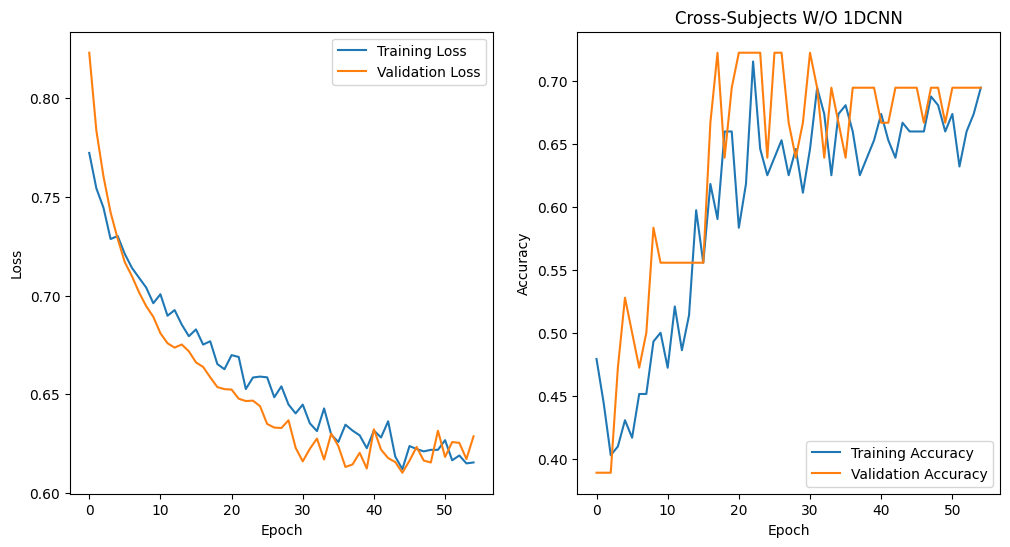

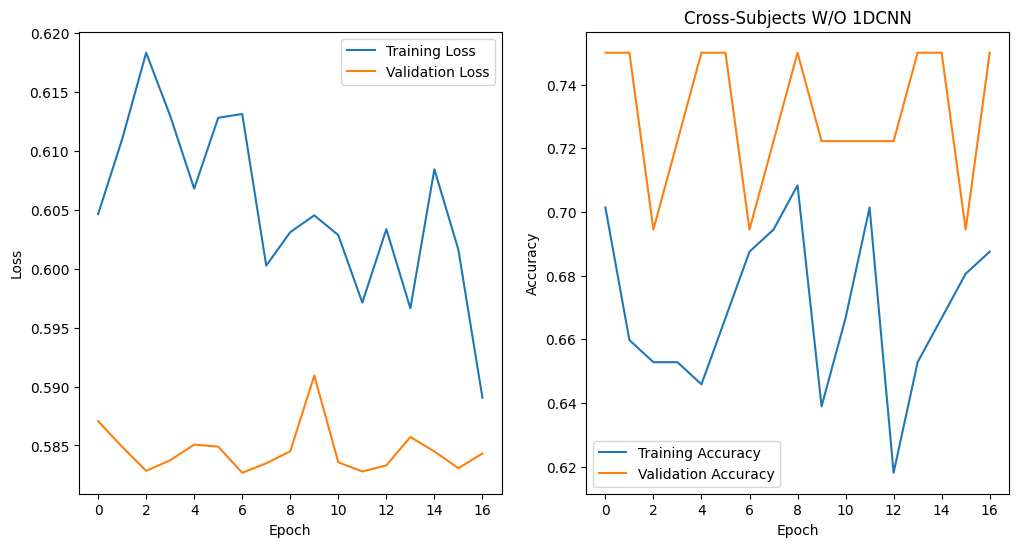

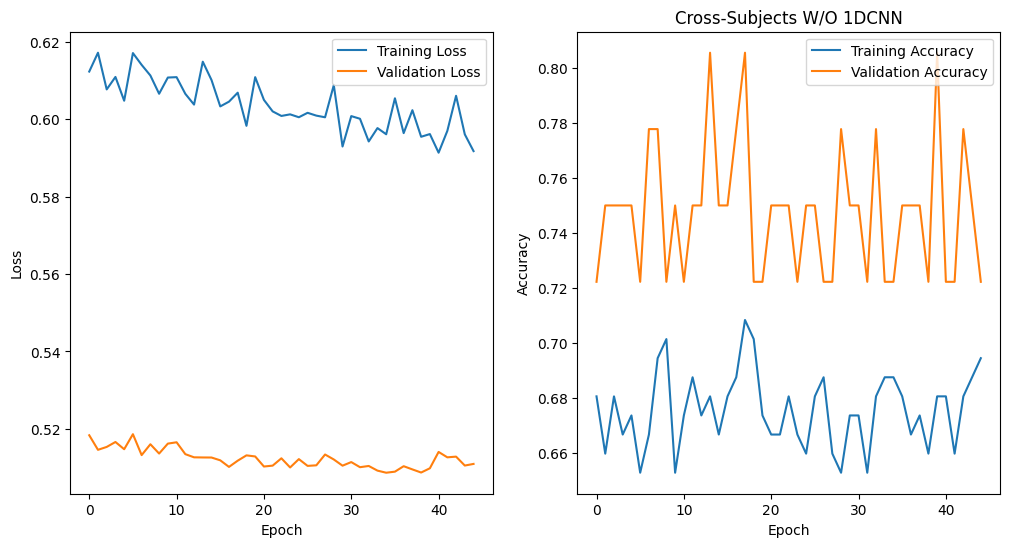

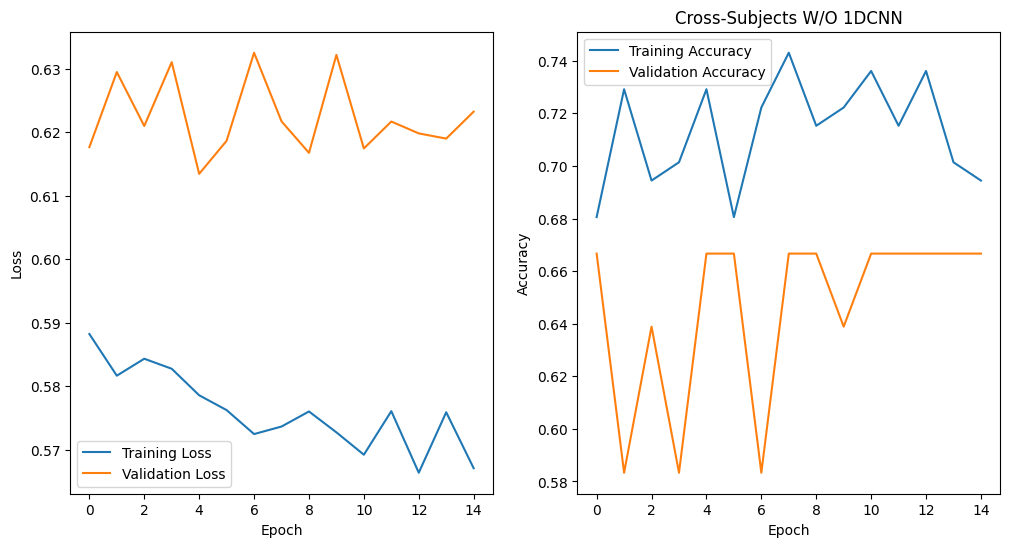

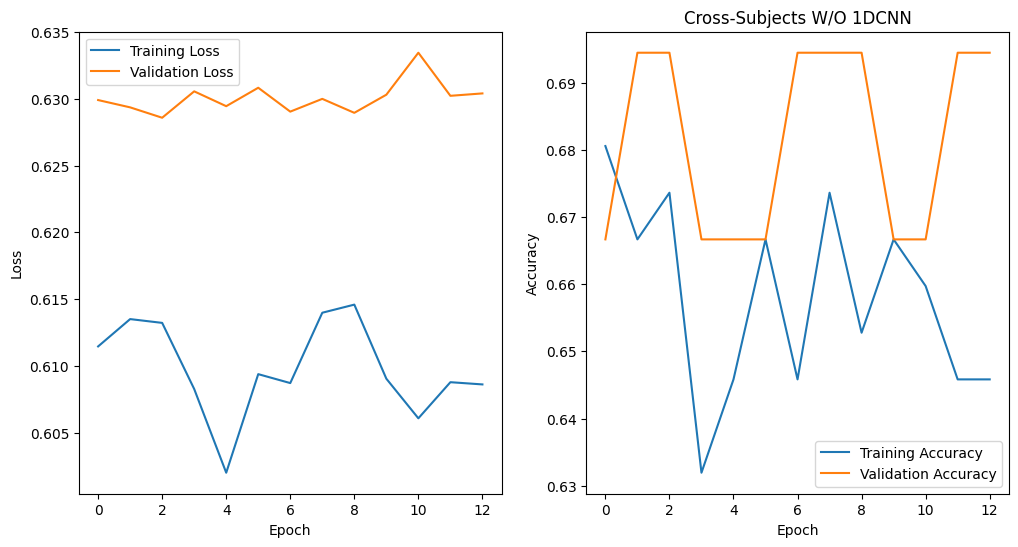

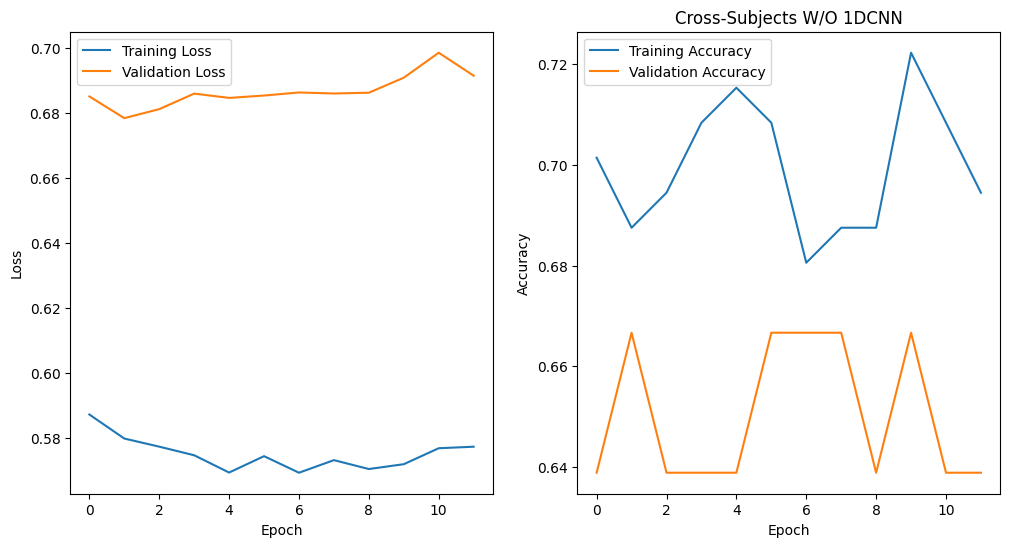

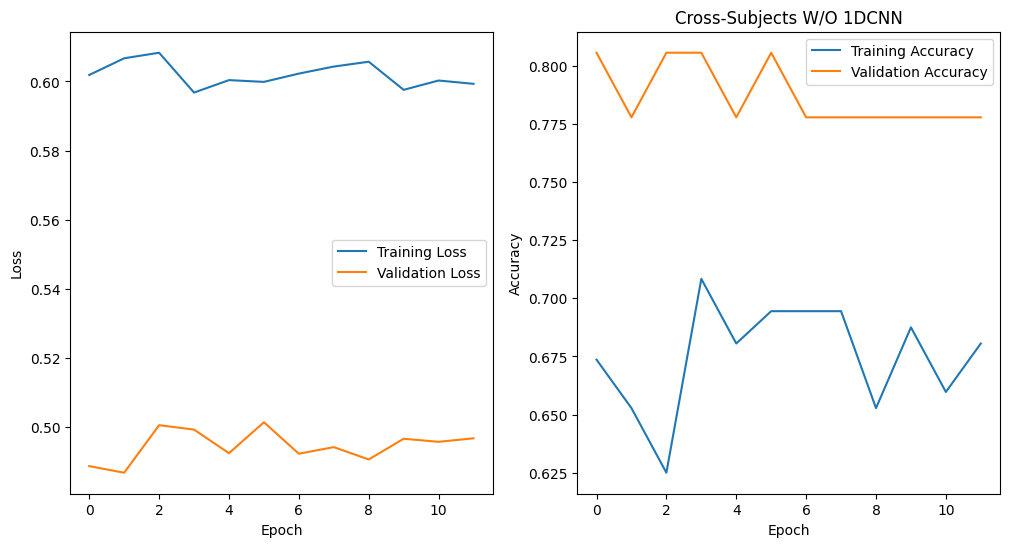

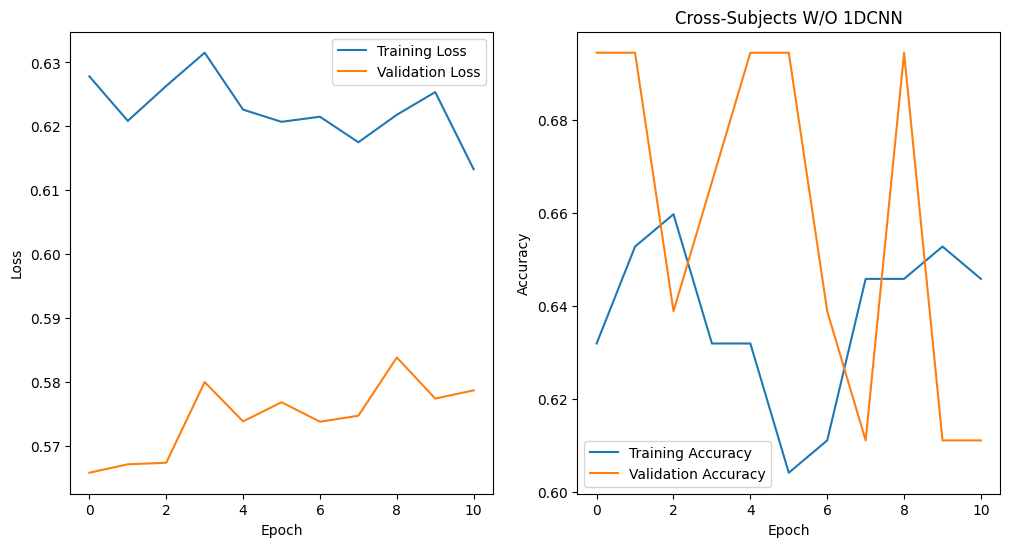

In [ ]:
# Define the channel names
channel_names = {
    9: "FCz",
    14: "Cz",
    19: "CPz",
    24: "Pz",
    28: "Oz"
}

iter = 50

# Initialize an empty dictionary to store the test accuracies for each channel
channel_accuracies = {}
# Initialize an empty dictionary to store the losses for each channel
channel_losses = {}

# Loop through the channel indices
for channel_name in channel_names:
  # Initialize lists to store the train, validation, and test accuracies for the current channel
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  train_losses = []
  val_losses = []
  test_losses = []
  f1_scores = []
  auc_scores = []

  model = EEGTransformer(
    seq_length=384,
    d_model=32,
    num_heads=6,
    num_layers=3,
    num_classes=2,
    dff=128,
    dropout_rate=0.35
  )

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.000008), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  for i in range(iter):
    # Extract the current channel data
    X_channel = X[:, channel_name, :]
    X_channel = np.expand_dims(X_channel, axis=-1)

    # Assuming x_normalized contains the preprocessed (normalized) epochs
    X_tensor = tf.convert_to_tensor(X_channel, dtype=tf.float32)

    # Assuming y contains the sleep stage labels
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)

    # Split the data into training (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_tensor.numpy(), y_tensor.numpy(), test_size=0.2)

    # Further split the training data into training (80%) and validation (20%) sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
    X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    batch_size = 16
    buffer_size = len(X_train)

    train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # Train the model
    epochs = 1000

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0
    )


    import matplotlib.pyplot as plt

    # Get training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get training and validation accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Create subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training and validation accuracy
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Cross-Subjects W/O 1DCNN')

    # Show the plot
    plt.show()

    # Get the training and validation accuracies and losses from the history object
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

    # Compute predictions for F1 and AUC scores for test data
    y_test_pred = model.predict(X_test, verbose = 0)

    y_pred_probs = y_test_pred[:, 1]

    # Convert probabilities to binary outputs
    y_test_pred_binary = np.argmax(y_test_pred, axis=-1)

    y_test_flatten = y_test.numpy().flatten()
    y_test_pred_flatten = y_test_pred_binary.flatten()

    # Compute F1 scores and AUC scores for test data
    test_f1_score = f1_score(y_test_flatten, y_test_pred_flatten)
    test_auc_score = roc_auc_score(y_test_flatten, y_pred_probs)

    # Append the F1 scores and AUC scores for test data to their respective lists
    f1_scores.append(test_f1_score)
    auc_scores.append(test_auc_score)

    # Append the accuracies and losses to their respective lists
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

  # Compute the average accuracies and losses for the current channel
  avg_train_accuracy = np.mean(train_accuracies)
  avg_val_accuracy = np.mean(val_accuracies)
  avg_test_accuracy = np.mean(test_accuracies)
  avg_train_loss = np.mean(train_losses)
  avg_val_loss = np.mean(val_losses)
  avg_test_loss = np.mean(test_losses)
  avg_f1_score = np.mean(f1_scores)
  avg_auc_score = np.mean(auc_scores)

  # Store the average accuracies and losses in the dictionaries
  channel_accuracies[channel_name] = {
      'train': avg_train_accuracy,
      'val': avg_val_accuracy,
      'test': avg_test_accuracy,
      'f1 score': avg_f1_score,
      'auc score': avg_auc_score,
  }
  channel_losses[channel_name] = {
      'train': avg_train_loss,
      'val': avg_val_loss,
      'test': avg_test_loss
  }

# Print the accuracies and losses for all channels
print(f"Channel accuracies and losses:")

# Prepare the table data
table_data = []
for channel, accuracies in channel_accuracies.items():
    losses = channel_losses[channel]
    channel_name = channel_names.get(channel, "Unknown")
    table_data.append([
        channel,
        channel_name,
        f"{accuracies['train']:.4f}",
        f"{losses['train']:.4f}",
        f"{accuracies['val']:.4f}",
        f"{losses['val']:.4f}",
        f"{accuracies['test']:.4f}",
        f"{losses['test']:.4f}",
        f"{accuracies['f1 score']:.4f}",
        f"{accuracies['auc score']:.4f}"
    ])

# Sort the table data by test accuracy in descending order
table_data.sort(key=lambda row: float(row[-2]), reverse=True)

# Define the table headers
headers = [
    "Channel",
    "Name",
    "Train Accuracy",
    "Train Loss",
    "Validation Accuracy",
    "Validation Loss",
    "Test Accuracy",
    "Test Loss",
    "F1 Score",
    "Auc Score",
]

# Print the table
print(tabulate(table_data, headers=headers))



# Evaluate Accuracy and Validity

In [ ]:
# from tabulate import tabulate

# # Define the channel names
# channel_names = {
#     4: "Fz",
#     9: "FCz",
#     14: "Cz",
#     19: "CPz",
#     24: "Pz",
#     28: "Oz"
# }

# # Print the accuracies for all channels
# print("All channel accuracies:")

# # Prepare the table data
# table_data = []
# for channel, accuracies in channel_accuracies.items():
#     channel_name = channel_names.get(channel, "Unknown")
#     table_data.append([
#         channel,
#         channel_name,
#         f"{accuracies['train']:.4f}",
#         f"{accuracies['val']:.4f}",
#         f"{accuracies['test']:.4f}"
#     ])

# # Sort the table data by test accuracy in descending order
# table_data.sort(key=lambda row: float(row[-1]), reverse=True)

# # Define the table headers
# headers = ["Channel", "Name", "Train Accuracy", "Validation Accuracy", "Test Accuracy"]

# # Print the table
# print(tabulate(table_data, headers=headers, tablefmt="grid"))

In [ ]:
# # Evaluate the model on the test dataset
# test_loss, test_acc = model.evaluate(test_dataset)

# # Get training and validation loss
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Get training and validation accuracy
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# print('Test accuracy:', test_acc)
# print('Val accuracy:', sum(val_acc)/len(val_acc))
# print('Train accuracy:', sum(train_acc)/len(train_acc))

In [ ]:
# import matplotlib.pyplot as plt

# # Get training and validation loss
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Get training and validation accuracy
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# # Create subplots for loss and accuracy
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot training and validation loss
# ax1.plot(train_loss, label='Training Loss')
# ax1.plot(val_loss, label='Validation Loss')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.legend()

# # Plot training and validation accuracy
# ax2.plot(train_acc, label='Training Accuracy')
# ax2.plot(val_acc, label='Validation Accuracy')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Accuracy')
# ax2.legend()

# # Show the plot
# plt.show()